# Домашнее задание 3. 

## Предсказание пользовательской оценки отеля по тексту отзыва.

В данном домашнем задании вам будет обучиться на данных с кэггла и заслать в [соревнование](https://www.kaggle.com/t/325e82797935464aa07c254b3cc3d8ad) предикт. Чтобы контест отображался, откройте и примите условия участия в контесте через ссылку-приглашение в телеграм-канале. По той же ссылке можете скачать данные.

Мы собрали для вас отзывы по 1500 отелям из совершенно разных уголков мира. Что это за отели - секрет. Вам дан текст отзыва и пользовательская оценка отеля. Ваша задача - научиться предсказывать оценку отеля по отзыву.

Главная метрика - Mean Absolute Error (MAE). Во всех частях домашней работы вам нужно получить значение MAE не превышающее 0.92 на публичном лидерборде. В противном случае мы будем вынуждены не засчитать задание :( 

#### Про данные:
Каждое ревью состоит из двух текстов: positive и negative - плюсы и минусы отеля. В столбце score находится оценка пользователя - вещественное число 0 до 10. Вам нужно извлечь признаки из этих текстов и предсказать по ним оценку.

Для локального тестирования используйте предоставленное разбиение на трейн и тест.

Good luck & have fun! 💪

#### Использовать любые данные для обучения кроме предоставленных организаторами строго запрещено. В последней части можно использовать предобученные модели из библиотеки `transformers`.

In [5]:
PATH_TO_TRAIN_DATA = '/content/train.csv'
PATH_TO_TEST_DATA = './test.csv'


import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split


In [24]:
! pip install gensim

In [74]:
! pip install catboost

     |████████████████████████████████| 76.1 MB 1.3 MB/s 


In [2]:
#! wget https://raw.githubusercontent.com/SaidDandamaev/Projects_of_Said_D/main/Work_files/train.csv

--2022-03-17 08:30:10--  https://raw.githubusercontent.com/SaidDandamaev/Projects_of_Said_D/main/Work_files/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-03-17 08:30:10 ERROR 404: Not Found.



In [3]:
#! wget https://raw.githubusercontent.com/SaidDandamaev/Projects_of_Said_D/main/Work_files/test.csv
#! wget https://raw.githubusercontent.com/hse-ds/iad-deep-learning/master/2021/seminars/sem07/utils.py

--2022-03-17 08:30:10--  https://raw.githubusercontent.com/SaidDandamaev/Projects_of_Said_D/main/Work_files/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-03-17 08:30:10 ERROR 404: Not Found.

--2022-03-17 08:30:11--  https://raw.githubusercontent.com/hse-ds/iad-deep-learning/master/2021/seminars/sem07/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1516 (1.5K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   1.48K  --.-KB/s    in 0s      

2022-03-17 08:30:11 (21.1 MB/s) 

In [6]:
df = pd.read_csv(PATH_TO_TRAIN_DATA)[:20000]
df.head()

,review_id,negative,positive,score
0,00003c6036f30f590c0ac435efb8739b,There were issues with the wifi connection,No Positive,7.1
1,00004d18f186bf2489590dc415876f73,TV not working,No Positive,7.5
2,0000cf900cbb8667fad33a717e9b1cf4,More pillows,Beautiful room Great location Lovely staff,10.0
3,0000df16edf19e7ad9dd8c5cd6f6925e,Very business,Location,5.4
4,00025e1aa3ac32edb496db49e76bbd00,Rooms could do with a bit of a refurbishment ...,Nice breakfast handy for Victoria train stati...,6.7


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   review_id  20000 non-null  object 
 1   negative   20000 non-null  object 
 2   positive   20000 non-null  object 
 3   score      20000 non-null  float64
dtypes: float64(1), object(3)
memory usage: 625.1+ KB



Предобработка текста может сказываться на качестве вашей модели.

Сделаем небольшой препроцессинг текстов: удалим знаки препинания, приведем все слова к нижнему регистру. 
Однако можно не ограничиваться этим набором преобразований. Подумайте, что еще можно сделать с текстами, чтобы помочь будущим моделям? Добавьте преобразования, которые могли бы помочь по вашему мнению.

Также мы добавили разбиение текстов на токены. Теперь каждая строка-ревью стала массивом токенов. ( у меня для 1 задания это будет не массив а все та же строка)

In [8]:
import string

import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize


nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
punctuation = string.punctuation 

noise = stopwords.words('english') + list(punctuation) + list('1234567890')
#noise = list(punctuation) + list('1234567890')

def process_text(text):
    lst =  [word for word in word_tokenize(text.lower()) if (word not in noise)]
    return ' '.join(lst)

In [10]:
df['negative'] = df['negative'].apply(process_text) # ячейка выполняется 30 сек
df['positive'] = df['positive'].apply(process_text)

In [11]:
df.head()

,review_id,negative,positive,score
0,00003c6036f30f590c0ac435efb8739b,issues wifi connection,positive,7.1
1,00004d18f186bf2489590dc415876f73,tv working,positive,7.5
2,0000cf900cbb8667fad33a717e9b1cf4,pillows,beautiful room great location lovely staff,10.0
3,0000df16edf19e7ad9dd8c5cd6f6925e,business,location,5.4
4,00025e1aa3ac32edb496db49e76bbd00,rooms could bit refurbishment could corridors ...,nice breakfast handy victoria train station si...,6.7


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   review_id  20000 non-null  object 
 1   negative   20000 non-null  object 
 2   positive   20000 non-null  object 
 3   score      20000 non-null  float64
dtypes: float64(1), object(3)
memory usage: 625.1+ KB


In [13]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1412) # <- для локального тестирования

### Часть 1. 1 балл

Обучите логистическую регрессию на TF-IDF векторах текстов.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.metrics import mean_absolute_error

In [15]:
count_tf_idf_neg = TfidfVectorizer()#ngram_range=(2,2))
count_tf_idf_pos = TfidfVectorizer()#ngram_range=(2,2))

tf_idf_pos_train = count_tf_idf_pos.fit_transform(df_train['positive'])
tf_idf_neg_train = count_tf_idf_neg.fit_transform(df_train['negative'])

tf_idf_pos_test = count_tf_idf_pos.transform(df_test['positive'])
tf_idf_neg_test = count_tf_idf_neg.transform(df_test['negative'])

In [16]:
X_train_pos = pd.DataFrame(tf_idf_pos_train.toarray(),columns=count_tf_idf_pos.get_feature_names())
X_train_neg = pd.DataFrame(tf_idf_neg_train.toarray(),columns=count_tf_idf_neg.get_feature_names())
X_train = pd.concat([X_train_neg.reset_index(drop=True), X_train_pos.reset_index(drop=True)], axis= 1)
del X_train_pos, X_train_neg 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [17]:
X_test_pos = pd.DataFrame(tf_idf_pos_test.toarray(),columns=count_tf_idf_pos.get_feature_names())
X_test_neg = pd.DataFrame(tf_idf_neg_test.toarray(),columns=count_tf_idf_neg.get_feature_names())
X_test = pd.concat([X_test_neg.reset_index(drop=True), X_test_pos.reset_index(drop=True)], axis= 1)
del X_test_pos, X_test_neg 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [18]:
%%time
model_1_log = SGDRegressor(max_iter=1000, random_state=1221) # r_s 1221 дает 0.9 на мае (выборка - 20000)
model_1_log.fit(X_train, df_train['score'])
mae_log = mean_absolute_error(df_test['score'], model_1_log.predict(X_test))
print(f'On Linear regression with TF-IDF MAE = {mae_log:.4f}')

On Linear regression with TF-IDF MAE = 0.9062
CPU times: user 1min 29s, sys: 874 ms, total: 1min 30s
Wall time: 1min 44s


Качество меньше 0.9 на всех выборках - great




Предскажите этой моделью тестовые данные из [соревнования](https://www.kaggle.com/t/325e82797935464aa07c254b3cc3d8ad) и сделайте сабмит. Какой у вас получился скор? Прикрепите скриншот из кэггла.

Score was about **0.89**

[![image.png](attachment:5f4469fe-90e0-4d25-8e31-b81a025dcc0b.png)](http://)

### Часть 2. 2 балла

Обучите линейную регрессию на усредненных **Word2Vec** векторах. 


In [19]:
noise = list(punctuation) + list('1234567890')

def process_text(text):
    lst =  [word for word in word_tokenize(text.lower()) if (word not in noise)]
    return ' '.join(lst)

In [20]:
df = pd.read_csv(PATH_TO_TRAIN_DATA)[:50000] # заного читаю, чтоб взять бОльшую выборку

df['negative'] = df['negative'].apply(process_text) # ячейка выполняется 30 сек
df['positive'] = df['positive'].apply(process_text)

In [21]:
df['positive'] = df['positive'].str.split()
df['negative'] = df['negative'].str.split()

In [22]:
df.head(3)

,review_id,negative,positive,score
0,00003c6036f30f590c0ac435efb8739b,"[there, were, issues, with, the, wifi, connect...","[no, positive]",7.1
1,00004d18f186bf2489590dc415876f73,"[tv, not, working]","[no, positive]",7.5
2,0000cf900cbb8667fad33a717e9b1cf4,"[more, pillows]","[beautiful, room, great, location, lovely, staff]",10.0


In [23]:
df3 = df.copy()

In [27]:
# взято с сайта https://medium.com/analytics-vidhya/word2vector-using-gensim-e055d35f1cb4
from gensim.models.word2vec import Word2Vec as w2v
import multiprocessing

emb_size = 200


arr_emb_size = []
arr_score_no_idf = []
arr_score_yes_idf = []

cpu_c = multiprocessing.cpu_count()
word_2_vec_model_pos = w2v(df['positive'], min_count=4, window=4, size=emb_size, workers=cpu_c)
word_2_vec_model_neg = w2v(df['negative'], min_count=4, window=4, size=emb_size, workers=cpu_c)

In [28]:
def make_arrays_for_text_pos(value):
    out_array = np.zeros(emb_size) 
    count = 0
    for el in value:
        try:
            out_array += word_2_vec_model_pos.wv[el]
            count += 1
        except:
            continue
    return out_array / count
# усредняем. Идею именно этой ячейки подсказал друг, но реализовал сам

def make_arrays_for_text_neg(value):
    out_array = np.zeros(emb_size) 
    count = 0
    for el in value:
        try:
            out_array += word_2_vec_model_neg.wv[el]
            count += 1
        except:
            continue
    return out_array / count

In [29]:
df2 = df.copy()
df['positive_vector'] = df['positive'].apply(make_arrays_for_text_pos)
df['negative_vector'] = df['negative'].apply(make_arrays_for_text_neg)

In [30]:
X_features = pd.DataFrame(np.hstack((np.array(list(df.iloc[:, 4].values)), 
                                     np.array(list(df.iloc[:, 5].values)))))

In [31]:
X_features['score'] = df['score']
X_features = X_features.fillna(0)
train, test = train_test_split(X_features, test_size=0.2, random_state = 1412)

In [32]:
model_2 = LinearRegression()
model_2.fit(train.drop('score', axis=1), train['score'])
no_idf_score = mean_absolute_error(model_2.predict(test.drop('score', axis=1)), test['score'])

In [33]:
print(f'MAE with Word2Vec medium = {no_idf_score:.4f}')

MAE with Word2Vec medium = 0.9465


Усредняя w2v вектора, мы предполагаем, что каждое слово имеет равноценный вклад в смысл предложения, однако это может быть не совсем так. Теперь попробуйте воспользоваться другой концепцией и перевзвесить слова при получении итогового эмбеддинга текста. В качестве весов используйте IDF (Inverse document frequency)

In [34]:
def calc_idf(needed_tf_idf):
    return dict(zip(needed_tf_idf.get_feature_names(), needed_tf_idf.idf_))

In [35]:
count_tf_idf_neg = TfidfVectorizer()
count_tf_idf_pos = TfidfVectorizer()

tf_idf_pos_train = count_tf_idf_pos.fit_transform(df_train['positive'])
tf_idf_neg_train = count_tf_idf_neg.fit_transform(df_train['negative'])

pos_dict_idf = calc_idf(count_tf_idf_pos)
neg_dict_idf = calc_idf(count_tf_idf_neg)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [36]:
def make_arrays_for_text_pos_idf(value):
    out_array = np.zeros(emb_size) 
    for el in value:
        try:
            out_array += word_2_vec_model_pos.wv[el] * pos_dict_idf[el]
        except:
            continue
    return out_array
# усредняем. Идею именно этой ячейки подсказал друг, но реализовал сам

def make_arrays_for_text_neg_idf(value):
    out_array = np.zeros(emb_size) 
    for el in value:
        try:
            out_array += word_2_vec_model_neg.wv[el] * neg_dict_idf[el]
        except:
            continue
    return out_array

In [37]:
df2['positive_vector'] = df2['positive'].apply(make_arrays_for_text_pos_idf)
df2['negative_vector'] = df2['negative'].apply(make_arrays_for_text_neg_idf)

In [38]:
df2.head()

,review_id,negative,positive,score,positive_vector,negative_vector
0,00003c6036f30f590c0ac435efb8739b,"[there, were, issues, with, the, wifi, connect...","[no, positive]",7.1,"[2.596295118331909, -0.6114968061447144, -0.98...","[-1.4462829232215881, 3.3961369395256042, 2.09..."
1,00004d18f186bf2489590dc415876f73,"[tv, not, working]","[no, positive]",7.5,"[2.596295118331909, -0.6114968061447144, -0.98...","[0.005304940044879913, 3.0429797172546387, 7.4..."
2,0000cf900cbb8667fad33a717e9b1cf4,"[more, pillows]","[beautiful, room, great, location, lovely, staff]",10.0,"[3.0791450248798355, 11.11297756433487, 6.5525...","[5.964325904846191, 0.9176493287086487, 4.6178..."
3,0000df16edf19e7ad9dd8c5cd6f6925e,"[very, business]",[location],5.4,"[0.6067295670509338, 0.6622955799102783, 0.132...","[0.39854106307029724, -1.3071905374526978, -2...."
4,00025e1aa3ac32edb496db49e76bbd00,"[rooms, could, do, with, a, bit, of, a, refurb...","[nice, breakfast, handy, for, victoria, train,...",6.7,"[1.8140106333885342, 21.551151582971215, -11.0...","[52.57218062132597, 10.658519186079502, 12.589..."


In [39]:
X_features = pd.DataFrame(np.hstack((np.array(list(df2.iloc[:, 4].values)), 
                                     np.array(list(df2.iloc[:, 5].values)))))

In [40]:
X_features['score'] = df2['score']
X_features = X_features.fillna(0)
train2, test2 = train_test_split(X_features, test_size=0.3, random_state = 1412)

In [41]:
model_3 = LinearRegression()
model_3.fit(train2.drop('score', axis=1), train2['score'])
idf_score = mean_absolute_error(test2['score'], model_3.predict(test2.drop('score', axis=1)))

In [42]:
print(f'MAE with Word2Vec IDF = {idf_score:.4f}')

MAE with Word2Vec IDF = 0.9300


Проведите эксперименты с размерностью эмбеддинга. Для каждого из двух методов постройте график зависимости качества модели от размерности эмбеддинга. 

#### Сделайте выводы:

Поиском по сетке найдем лучшую модель

In [46]:
import time
start_time = time.time()

arr_emb_size = []
arr_score_no_idf = []
arr_score_yes_idf = []
for emb_size in tqdm(range(300, 701, 100)):
    
    arr_emb_size.append(emb_size)

    cpu_c = multiprocessing.cpu_count()
    word_2_vec_model_pos = w2v(df['positive'], min_count=4, window=4, size=emb_size, workers=cpu_c, 
                               iter=15)
    word_2_vec_model_neg = w2v(df['negative'], min_count=4, window=4, size=emb_size, workers=cpu_c, 
                               iter=15)
    df = df3.copy()
    df2 = df.copy()
    df['positive_vector'] = df['positive'].apply(make_arrays_for_text_pos)
    df['negative_vector'] = df['negative'].apply(make_arrays_for_text_neg)
    X_features = pd.DataFrame(np.hstack((np.array(list(df.iloc[:, 4].values)), 
                                     np.array(list(df.iloc[:, 5].values)))))
    X_features['score'] = df['score']
    X_features = X_features.fillna(0)
    train, test = train_test_split(X_features, test_size=0.2, random_state = 1412)
    
    model_2 = LinearRegression()
    model_2.fit(train.drop('score', axis=1), train['score'])
    no_idf_score = mean_absolute_error(model_2.predict(test.drop('score', axis=1)), test['score'])
    
    arr_score_no_idf.append(no_idf_score)
    
    df2['positive_vector'] = df2['positive'].apply(make_arrays_for_text_pos_idf)
    df2['negative_vector'] = df2['negative'].apply(make_arrays_for_text_neg_idf)
    
    X_features = pd.DataFrame(np.hstack((np.array(list(df2.iloc[:, 4].values)), 
                                     np.array(list(df2.iloc[:, 5].values)))))
    
    X_features['score'] = df2['score']
    X_features = X_features.fillna(0)
    train2, test2 = train_test_split(X_features, test_size=0.3, random_state = 1412)
    
    model_3 = LinearRegression()
    model_3.fit(train2.drop('score', axis=1), train2['score'])
    idf_score = mean_absolute_error(test2['score'], model_3.predict(test2.drop('score', axis=1)))
    
    arr_score_yes_idf.append(idf_score)
    
print("--- %s seconds ---" % (round(time.time() - start_time, 4)))

100%|██████████| 5/5 [07:40<00:00, 92.20s/it]

--- 461.0058 seconds ---


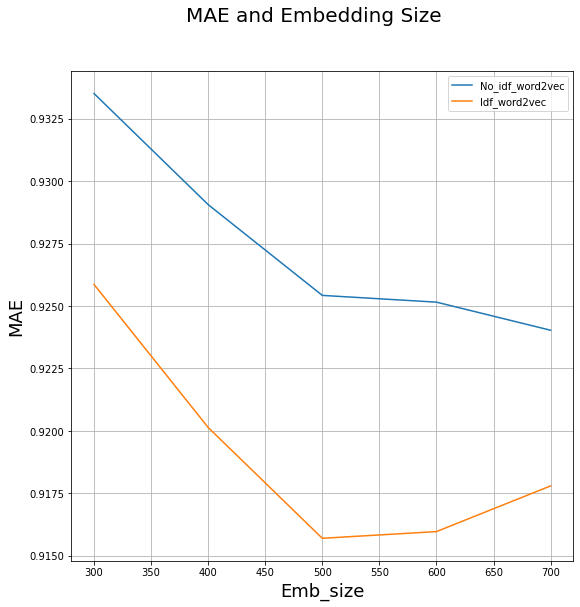

In [47]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,9))

plt.plot(arr_emb_size, arr_score_no_idf, label = "No_idf_word2vec")
plt.plot(arr_emb_size, arr_score_yes_idf, label = "Idf_word2vec")
fig.suptitle('MAE and Embedding Size', fontsize=20)
plt.xlabel('Emb_size', fontsize=18)
plt.ylabel('MAE', fontsize=18)
plt.legend()
plt.grid()
plt.show()

лучший эмбеддинг при emb_size = 500

In [49]:
import time
start_time = time.time()

best_min_count = 0
best_window = 0
best_res = 11
arr_score_no_idf = []


best_min_count_idf = 0
best_window_idf = 0
best_res_idf = 11
best_mod_no_idf = None


arr_score_idf = []
best_model_idf = None
best_w_2_v_pos = None
best_w_2_v_neg = None

#arr_score_yes_idf = []
for windows in tqdm([7, 8]):
    for min_count in tqdm([ 5, 6]):
        emb_size = 500
        
        
        cpu_c = multiprocessing.cpu_count()
        word_2_vec_model_pos = w2v(df['positive'], min_count=min_count, 
                                   window=windows, size=emb_size, workers=cpu_c, seed=122, iter=15)
        word_2_vec_model_neg = w2v(df['negative'], min_count=min_count, 
                                   window=windows, size=emb_size, workers=cpu_c, seed=1223, iter=15)
        df = df3.copy()
        df2 = df.copy()
        df['positive_vector'] = df['positive'].apply(make_arrays_for_text_pos)
        df['negative_vector'] = df['negative'].apply(make_arrays_for_text_neg)
        X_features = pd.DataFrame(np.hstack((np.array(list(df.iloc[:, 4].values)), 
                                         np.array(list(df.iloc[:, 5].values)))))
        X_features['score'] = df['score']
        X_features = X_features.fillna(0)
        train, test = train_test_split(X_features, test_size=0.2, random_state = 1412)

        model_2 = LinearRegression()
        model_2.fit(train.drop('score', axis=1), train['score'])
        no_idf_score = mean_absolute_error(model_2.predict(test.drop('score', axis=1)), test['score'])

        arr_score_no_idf.append(no_idf_score)
        
        if no_idf_score < best_res:
            best_res = no_idf_score
            best_window = windows
            best_min_count = min_count
            best_mod_no_idf = model_2
        
        df2['positive_vector'] = df2['positive'].apply(make_arrays_for_text_pos_idf)
        df2['negative_vector'] = df2['negative'].apply(make_arrays_for_text_neg_idf)

        X_features = pd.DataFrame(np.hstack((np.array(list(df2.iloc[:, 4].values)), 
                                         np.array(list(df2.iloc[:, 5].values)))))

        X_features['score'] = df2['score']
        X_features = X_features.fillna(0)
        print(X_features.shape)
        train2, test2 = train_test_split(X_features, test_size=0.2, random_state = 1412)

        model_3 = LinearRegression()
        model_3.fit(train2.drop('score', axis=1), train2['score'])
        idf_score = mean_absolute_error(test2['score'], model_3.predict(test2.drop('score', axis=1)))
        
        if idf_score < best_res_idf:
            best_res_idf = idf_score
            best_window_idf = windows
            best_min_count_idf = min_count
            best_model_idf = model_3
            best_w_2_v_pos = word_2_vec_model_pos
            best_w_2_v_neg = word_2_vec_model_neg
            

    
print("--- %s seconds ---" % (round(time.time() - start_time, 4)))

  0%|          | 0/2 [00:00<?, ?it/s]

(50000, 1001)



 50%|█████     | 1/2 [01:39<01:39, 99.67s/it]

(50000, 1001)



  0%|          | 0/2 [00:00<?, ?it/s]

(50000, 1001)



 50%|█████     | 1/2 [01:36<01:36, 96.08s/it]

(50000, 1001)



100%|██████████| 2/2 [06:22<00:00, 191.40s/it]

--- 382.8225 seconds ---


In [50]:
print('Without IDF best res = {}, parameters = {} and {}'.format(best_res, best_window, best_min_count))
print('With IDF best res = {}, parameters = {} and {}'.format(best_res_idf, best_window_idf, best_min_count_idf))

Without IDF best res = 0.9268714831873073, parameters = 8 and 5
With IDF best res = 0.9119240812649141, parameters = 7 and 5


Теперь попробуйте обучить логистическую регрессию на любых других эмбеддингах размерности 300 и сравните качество с Word2Vec.
#### Выводы:
Я выбил нужное качество - **менее 0.92**! В итоге надо было не убирать Стоп-слова, и тогда ворд2век контекст лучше понимает


In [51]:
def make_arrays_for_text_pos_idf_fast_text(value):
    out_array = np.zeros(emb_size)
    count = 0
    for el in value:
        try:
            out_array += fast_text_model_pos.wv[el]
            count += 1
        except:
            continue
    return out_array / count
# усредняем. Идею именно этой ячейки подсказал друг, но реализовал сам

def make_arrays_for_text_neg_idf_fast_text(value):
    out_array = np.zeros(emb_size) 
    count = 0
    for el in value:
        try:
            out_array += fast_text_model_neg.wv[el] 
            count += 1
        except:
            continue
    return out_array / count

In [52]:
def make_arrays_for_text_pos_idf(value):
    out_array = np.zeros(emb_size) 
    for el in value:
        try:
            out_array += best_w_2_v_pos.wv[el] * pos_dict_idf[el]
        except:
            continue
    return out_array
# усредняем. Идею именно этой ячейки подсказал друг, но реализовал сам

def make_arrays_for_text_neg_idf(value):
    out_array = np.zeros(emb_size) 
    for el in value:
        try:
            out_array += best_w_2_v_neg.wv[el] * neg_dict_idf[el]
        except:
            continue
    return out_array

In [54]:
from gensim.models.fasttext import FastText as FT

fast_text_model_pos = FT(df['positive'], size=300, workers=cpu_c, sg=1, seed=3, iter=20)
fast_text_model_neg = FT(df['negative'], size=300, workers=cpu_c, sg=1, seed=3, iter=20)
print('Going well')

df = df3.copy()
df2 = df.copy()
df2['positive_vector'] = df2['positive'].apply(make_arrays_for_text_pos_idf_fast_text)
df2['negative_vector'] = df2['negative'].apply(make_arrays_for_text_neg_idf_fast_text)

X_features = pd.DataFrame(np.hstack((np.array(list(df2.iloc[:, 4].values)), 
                                 np.array(list(df2.iloc[:, 5].values)))))

X_features['score'] = df2['score']
X_features = X_features.fillna(0)
train2, test2 = train_test_split(X_features, test_size=0.3, random_state = 1412)

model_4 = LinearRegression()
model_4.fit(train2.drop('score', axis=1), train2['score'])
mean_absolute_error(test2['score'], model_4.predict(test2.drop('score', axis=1)))

Going well


1.3115023481904762

In [ ]:
# data_test = pd.read_csv(PATH_TO_TEST_DATA)
# data_test['negative'] = data_test['negative'].apply(process_text) # ячейка выполняется 30 сек
# data_test['positive'] = data_test['positive'].apply(process_text)

# data_test['positive'] = data_test['positive'].str.split()
# data_test['negative'] = data_test['negative'].str.split()

# data_test['positive_vector'] = data_test['positive'].apply(make_arrays_for_text_pos_idf)
# data_test['negative_vector'] = data_test['negative'].apply(make_arrays_for_text_neg_idf)

# X_featurest = pd.DataFrame(np.hstack((np.array(list(data_test.loc[:, 'positive_vector'].values)), 
#                                          np.array(list(data_test.loc[:, 'negative_vector'].values)))))

# X_featurest = X_featurest.fillna(0)


# pred = best_model_idf.predict(X_featurest)

# pd.DataFrame({'review_id': data_test['review_id'], 'score': pred}).to_csv('My_sub2.3.csv',index=False)

Предскажите вашей лучшей моделью из этого задания тестовые данные из [соревнования](https://www.kaggle.com/t/325e82797935464aa07c254b3cc3d8ad) и сделайте сабмит. Какой у вас получился скор? Прикрепите скриншот из кэггла.

[![image.png](attachment:3b195f8d-cc6c-41d9-8fc5-0323e89db542.png)](http://)

Я сделал модель, которая у меня в разбиение набирает нужные 0.91, а в кэгле это очень близко к этому. Ворд 2 век показал неплохо себя, хоть и хуже tf-idf, fasttext у меня плоховато сработал

### Часть 3. 4 балла

Теперь давайте воспользуемся более продвинутыми методами обработки текстовых данных, которые мы проходили в нашем курсе. Обучите RNN/Transformer для предсказания пользовательской оценки. Получите ошибку меньше, чем во всех вышеперечисленных методах.

Если будете обучать RNN, попробуйте ограничить максимальную длину предложения. Некоторые отзывы могут быть слишком длинные относительно остальных.

Чтобы пользоваться DataLoader, все его элементы должны быть одинаковой размерности. Для этого вы можете добавить нулевой паддинг ко всем предложениям (см пример pad_sequence)

In [55]:
import torch
from torch import nn
from torch.nn import functional as F
import random

In [56]:
df_rnn = pd.read_csv(PATH_TO_TRAIN_DATA)[:50000]
df_rnn.head(3)

,review_id,negative,positive,score
0,00003c6036f30f590c0ac435efb8739b,There were issues with the wifi connection,No Positive,7.1
1,00004d18f186bf2489590dc415876f73,TV not working,No Positive,7.5
2,0000cf900cbb8667fad33a717e9b1cf4,More pillows,Beautiful room Great location Lovely staff,10.0


In [57]:
noise = stopwords.words('english') + list(punctuation) + list('1234567890')
#noise = list(punctuation) + list('1234567890')

def process_text(text):
    lst =  [word for word in word_tokenize(text.lower()) if (word not in noise)]
    return lst

df_rnn['positive'] = df_rnn['positive'].apply(process_text)
df_rnn['negative'] = df_rnn['negative'].apply(process_text)
df_rnn.head()

,review_id,negative,positive,score
0,00003c6036f30f590c0ac435efb8739b,"[issues, wifi, connection]",[positive],7.1
1,00004d18f186bf2489590dc415876f73,"[tv, working]",[positive],7.5
2,0000cf900cbb8667fad33a717e9b1cf4,[pillows],"[beautiful, room, great, location, lovely, staff]",10.0
3,0000df16edf19e7ad9dd8c5cd6f6925e,[business],[location],5.4
4,00025e1aa3ac32edb496db49e76bbd00,"[rooms, could, bit, refurbishment, could, corr...","[nice, breakfast, handy, victoria, train, stat...",6.7


In [58]:
WORDS = set()
for sent in list(df_rnn['positive']):
    for w in sent:
        WORDS.add(w)
        
for sent in list(df_rnn['negative']):
    for w in sent:
        WORDS.add(w)

In [59]:
int2word = dict(enumerate(tuple(WORDS)))
word2int = {w: ii for ii, w in int2word.items()}

In [60]:
len(WORDS)

24544

In [61]:
MAX_LEN = max(max(df_rnn['positive'].apply(len)), max(df_rnn['negative'].apply(len)))

In [62]:
device = 'cuda:0'

MAX_LEN

210

In [63]:
from torch.nn.utils.rnn import pad_sequence

df_train, df_test = train_test_split(df_rnn, test_size=0.2, random_state=1412) # <- для локального тестирования


train_pos_pad = pad_sequence([torch.as_tensor([word2int[w] for w in seq][:int(MAX_LEN - 0.15* MAX_LEN)]) for seq in df_train['positive']], 
                           batch_first=True)
train_neg_pad = pad_sequence([torch.as_tensor([word2int[w] for w in seq][:int(MAX_LEN - 0.15* MAX_LEN)]) for seq in df_train['negative']], 
                           batch_first=True)

In [64]:
train_pad = torch.cat([train_pos_pad,train_neg_pad ], 1)

In [65]:
class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        try:
            self.X = X.numpy()
            self.y = y.to_numpy()
        except:
            self.X = X.numpy()
            self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(752979) 

In [66]:
BATCH_SIZE = 170

features_train, features_test, y_train, y_test = train_test_split(train_pad, df_train['score'],
                                                                 test_size=0.2, random_state=1312125)

train_dataset = ReviewsDataset(features_train, y_train)
test_dataset = ReviewsDataset(features_test, y_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [68]:
class LSTMRegressor(nn.Module):
    def __init__(self, hidden_dim, label_size, num_emb = len(WORDS), embedding_dim=600, bidirectional = True):
        super(LSTMRegressor, self).__init__()
        
        self.emb = nn.Embedding(num_emb, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,
                            bidirectional = bidirectional,batch_first=True)
        if bidirectional:
            self.layers = nn.Sequential(
            nn.Linear(hidden_dim*2, 200),
            nn.Dropout(p=0.2),
                nn.LeakyReLU(),

    
           
            nn.Linear(200, label_size)
            )
        else:
            self.fc = nn.Linear(hidden_dim, label_size)
        self.act1 = nn.ReLU()
 
    def forward(self, x):
        embeds = self.emb(x)
 
        packed_outputs, (hidden,cell) = self.lstm(embeds)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
         
        output = self.layers(hidden)
        return output.squeeze()

In [69]:
def train_epoch(
    model,
    data_loader,
    optimizer,
    criterion,
    return_losses=False,
    device="cuda:0",
):
    model = model.to(device).train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])#.reshape((0, ))
    total_labels = np.array([])#.reshape((0, ))
    for item in data_loader:
        images = item[0]
        labels = item[1]

        # Move Batch to GPU
        images = images.to(device)
        labels = labels.to(device)
        predicted = model(images.long())
        predicted[predicted > 10] = 10
        predicted[predicted < 0] = 0
        loss = criterion(predicted.float(), labels)
        # Update weights
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # Update descirption for tqdm
        total_loss += loss.item()
        num_batches += 1
        all_losses.append(loss.detach().item())
    metrics = {"loss": total_loss / num_batches}
    return model


def validate(model, data_loader, criterion, device="cuda:0"):
    model = model.eval()
    total_loss = 0
    num_batches = 0
    predicts = np.array([])
    total_predictions = np.array([])
    total_labels = np.array([])
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)
        predicted = model(images.long())
        predicted[predicted > 10] = 10
        predicted[predicted < 0] = 0
        loss = criterion(predicted.float(), labels)
        predicts = np.append(predicts, predicted.cpu().detach().numpy())
        total_loss += loss.item()
        num_batches += 1
    metrics = {"loss": total_loss / num_batches, 'answers': predicts}
    return metrics

In [70]:
model = LSTMRegressor(hidden_dim=120, label_size=1)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda = lambda epoch: 0.95) 
loss_function = nn.L1Loss()

In [71]:
NUM_EPOCHS = 14

def train_epochs(model,
    data_loader_train,
    data_loader_test,
    optimizer,
    criterion,scheduler,
    return_losses=False,
    device="cuda:0", epochs = NUM_EPOCHS):
    for jj in tqdm(range(NUM_EPOCHS)):
        model = train_epoch(model, data_loader_train, optimizer, criterion, return_losses=False, device="cuda:0")

        metrics = validate(model, data_loader_test, criterion)
        print('On epoch {} MAE = {:.4f}'.format(jj + 1,metrics['loss']))
        scheduler.step()
    
    return model
      
model = train_epochs(model, train_dataloader, test_dataloader, optimizer, loss_function, scheduler)
print()

  7%|▋         | 1/14 [01:00<13:02, 60.20s/it]

On epoch 1 MAE = 1.1547


 14%|█▍        | 2/14 [01:51<11:02, 55.18s/it]

On epoch 2 MAE = 1.0570


 21%|██▏       | 3/14 [02:43<09:49, 53.55s/it]

On epoch 3 MAE = 0.9999


 29%|██▊       | 4/14 [03:35<08:47, 52.75s/it]

On epoch 4 MAE = 0.9446


 36%|███▌      | 5/14 [04:26<07:50, 52.27s/it]

On epoch 5 MAE = 0.8947


 43%|████▎     | 6/14 [05:17<06:55, 51.99s/it]

On epoch 6 MAE = 0.8721


 50%|█████     | 7/14 [06:09<06:02, 51.78s/it]

On epoch 7 MAE = 0.8648


 57%|█████▋    | 8/14 [07:00<05:09, 51.66s/it]

On epoch 8 MAE = 0.8584


 64%|██████▍   | 9/14 [07:52<04:17, 51.59s/it]

On epoch 9 MAE = 0.8576


 71%|███████▏  | 10/14 [08:43<03:26, 51.54s/it]

On epoch 10 MAE = 0.8577


 79%|███████▊  | 11/14 [09:34<02:34, 51.52s/it]

On epoch 11 MAE = 0.8584


 86%|████████▌ | 12/14 [10:26<01:42, 51.49s/it]

On epoch 12 MAE = 0.8560


 93%|█████████▎| 13/14 [11:17<00:51, 51.41s/it]

On epoch 13 MAE = 0.8638


100%|██████████| 14/14 [12:08<00:00, 52.07s/it]

On epoch 14 MAE = 0.8504



Итого, нейронная сеть дала нам лучшее  качество - 0.85!

### Контест (до 3 баллов)

По итогам всех ваших экспериментов выберите модель, которую считаете лучшей. Сделайте сабмит в контест. В зависимости от вашего скора на публичном лидерборде, мы начислим вам баллы:

 - <0.77 - 3 балла
 - [0.77; 0.78) - 2 балла
 - [0.78; 0.8) - 1 балл

Тут я решил взять Градиентный бустинг на ворд2веке применить все это друг на друга. Удалось выбить 0.79 на внутреннем разбиении

In [72]:
def make_arrays_for_text_pos_idf(value):
    out_array = np.zeros(emb_size) 
    for el in value:
        try:
            out_array += best_w_2_v_pos.wv[el] * pos_dict_idf[el]
        except:
            continue
    return out_array
# усредняем. Идею именно этой ячейки подсказал друг, но реализовал сам

def make_arrays_for_text_neg_idf(value):
    out_array = np.zeros(emb_size) 
    for el in value:
        try:
            out_array += best_w_2_v_neg.wv[el] * neg_dict_idf[el]
        except:
            continue
    return out_array

In [73]:
df = df3.copy()
df2 = df.copy()
df2['positive_vector'] = df2['positive'].apply(make_arrays_for_text_pos_idf)
df2['negative_vector'] = df2['negative'].apply(make_arrays_for_text_neg_idf)

X_features = pd.DataFrame(np.hstack((np.array(list(df2.iloc[:, 4].values)), 
                                         np.array(list(df2.iloc[:, 5].values)))))

X_features['score'] = df2['score']
X_features = X_features.fillna(0)
print(X_features.shape)
train2, test2 = train_test_split(X_features, test_size=0.2, random_state = 1412)


(50000, 1001)


In [75]:
from catboost import CatBoostRegressor
model_gb = CatBoostRegressor(iterations=1000,
                          learning_rate=0.05,
                          depth=7, random_state=200, silent=True, loss_function='MAE')

In [76]:
%%time
model_gb.fit(train2.drop('score', axis=1), train2['score'])
mean_absolute_error(test2['score'], model_gb.predict(test2.drop('score', axis=1)))

CPU times: user 20min 32s, sys: 5.11 s, total: 20min 37s
Wall time: 11min 24s


In [77]:
mean_absolute_error(test2['score'], model_gb.predict(test2.drop('score', axis=1)))

0.7923591316258195

Final score = `0.79`